In [163]:
%pylab inline
import pickle
import pandas


# Random forest routine from scikit-learn:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
# Cross-Validation routines:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from photerr import LsstErrorModel

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [164]:
import glob
   

In [165]:
#df_full=pandas.read_pickle('/global/u2/q/qhang/desc/notebooks_for_analysis/Project285/cosmoDC2_pzflow_sample.pkl')

df_full=pandas.read_pickle('/pscratch/sd/q/qhang/roman-rubin-sims/nonuniform-maf/roman_rubin_2023_v1.1.3_elais-subset.pkl')

Text(0, 0.5, 'g-i')

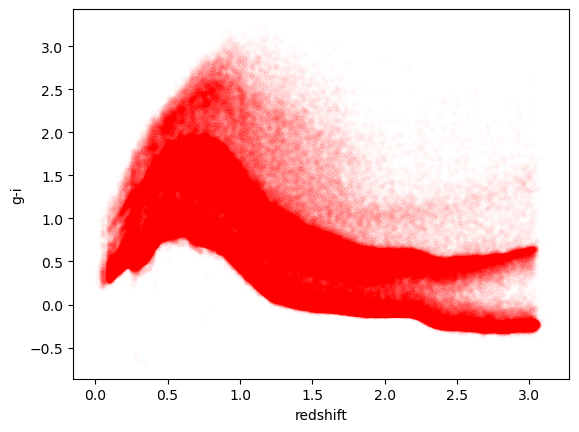

In [166]:
plt.plot(df_full['redshift'],df_full['g']-df_full['i'],'r.', alpha=0.01)
plt.xlabel('redshift')
plt.ylabel('g-i')

In [167]:
#This is a function that makes a plot of photometric redshift 
#    as a function of spectroscopic redshift 
#    and calculates key statistics.  It will save us a lot of work.
def plot_and_stats(zspec,zphot):
    
    z_spec = np.copy(zspec)
    z_phot=np.copy(zphot)
    x = np.arange(0,5.4,0.05)

# define differences of >0.15*(1+z) as non-Gaussian 'outliers'    
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
#Standard Deviation of the predicted redshifts compared to the data:
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)

#Normalized MAD (Median Absolute Deviation):
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))

#Percentage of delta-z > 0.15(1+z) outliers:
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    
    #Median offset (normalized by (1+z); i.e., bias:
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    
    # make photo-z/spec-z plot
    plt.figure(figsize=(8, 8))
    
    #add lines to indicate outliers
    plt.plot(x, outlier_upper, 'k--')
    plt.plot(x, outlier_lower, 'k--')
    plt.plot(z_spec[mask], z_phot[mask], 'r.', markersize=6,  alpha=0.05)
    plt.plot(z_spec[notmask], z_phot[notmask], 'b.',  markersize=6, alpha=0.05)
    plt.plot(x, x, linewidth=1.5, color = 'red')
    plt.title('$\sigma_\mathrm{NMAD} \ = $%6.4f\n'%nmad+'$(\Delta z)>0.15(1+z) $ outliers = %6.3f'%(eta*100)+'%', fontsize=18)
    plt.xlim([0.0, 2])
    plt.ylim([0.0, 2])
    plt.xlabel('$z_{\mathrm{spec}}$', fontsize = 27)
    plt.ylabel('$z_{\mathrm{photo}}$', fontsize = 27)
    plt.grid(alpha = 0.8)
    plt.tick_params(labelsize=15)
    plt.show()
    

In [168]:
#from Ellen
# some float64 issues going on with photerr:

nominal_depth_LSSTY10 = {
    "u":25.6,
    "g":26.9,
    "r":26.9,
    "i":26.4,
    "z":25.6,
    "y":24.8,
}

In [169]:
#from Ellen
# calculate nominal depths etc.
years=np.arange(1,11)
n_ilim=len(years)
ilims = 25.3+2.5/2.0*np.log10(years/10)
print("i_lim", ilims)
n_m5 = 11


nominal_depth={}
for band in ["u","g","r","i","z","y"]:
    nominal_depth[band] = {}
    for year in years:
        #nominal_depth[band][year]= nominal_depth_LSSTv1[band]+2.5/2.0*np.log10(year)
        nominal_depth[band][year]= nominal_depth_LSSTY10[band]+2.5/2.0*np.log10(year/10)
#    print(band, nominal_depth[band])
    
# finally compute the M5 bins in each band:
M5 = {}
for band in ["u","g","r","i","z","y"]:
    M5[band]={}
    for year in years:
        M5[band][year] = np.linspace(-5,5,n_m5)*0.1 +  nominal_depth[band][year]




i_lim [24.05       24.42628749 24.64640157 24.80257499 24.92371251 25.02268906
 25.10637255 25.17886248 25.24280314 25.3       ]


In [170]:
# code to produce a catalog degraded according to the depths in a particular year
def degrade_catalog(df_full,year):

#code from Ellen
# what we want to do here is to degrade the sample and save them in a separate catalogue;

    extendedType="auto"

    catalog_rep = df_full.copy()
    
    nominal_depth_LSSTY10 = {
    "u":25.6,
    "g":26.9,
    "r":26.9,
    "i":26.4,
    "z":25.6,
    "y":24.8,
}

    nominal_depth={}
    for band in ["u","g","r","i","z","y"]:
        nominal_depth[band] = {}
        nominal_depth[band]= nominal_depth_LSSTY10[band]+2.5/2.0*np.log10(year/10)

# we should save the binning in each band:

    for band in ["u","g","r","i","z","y"]:
        
    # these are nominal values
        nVisYr={}
        m5={}
        for bb in ["u","g","r","i","z","y"]:
            nVisYr[bb]=1
            m5[bb]=nominal_depth[bb]
        
        errModel = LsstErrorModel(nYrObs=1,nVisYr=nVisYr[bb],m5={"u": float(m5["u"]),
                                                                "g": float(m5["g"]),
                                                                "r": float(m5["r"]),
                                                                "i": float(m5["i"]),
                                                                 "z": float(m5["z"]),
                                                                "y": float(m5["y"])},
                                     extendedType=extendedType)
        tmpcatalog = errModel(catalog_rep, random_state=np.random.randint(1,100_000))
   
        if 'redshift' in catalog_rep.columns:
             d = {
                "u": (tmpcatalog["u"].to_numpy()),
                "g": (tmpcatalog["g"].to_numpy()),
                "r": (tmpcatalog["r"].to_numpy()),
                "i": (tmpcatalog["i"].to_numpy()),
                "z": (tmpcatalog["z"].to_numpy()),
                "y": (tmpcatalog["y"].to_numpy()),
                "redshift": (catalog_rep['redshift'].to_numpy()),
        }
        else:
            d = {
                "u": (tmpcatalog["u"].to_numpy()),
                "g": (tmpcatalog["g"].to_numpy()),
                "r": (tmpcatalog["r"].to_numpy()),
                "i": (tmpcatalog["i"].to_numpy()),
                "z": (tmpcatalog["z"].to_numpy()),
                "y": (tmpcatalog["y"].to_numpy()),
        }
    degraded_cat = pandas.DataFrame(data=d)
    return(degraded_cat)
    

In [171]:
# code to train the random forests
def train_rf(catalog,plot=False):

    u_mag = catalog['u']
    g_mag = catalog['g']
    r_mag = catalog['r']
    i_mag = catalog['i']
    z_mag = catalog['z']
    y_mag = catalog['y']

#Redshift array
    z = catalog['redshift']

# Now, set up input data array for scikit-learn regression algorithms
# We will include galaxy colors (expressed as differences between magnitudes
# in adjoining bands) and one magnitude.
# np.column_stack makes a 2D array out of a set of 1d arrays :
# with 6 variables we get an N x 6 numpy array out
    data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, 
                               i_mag-z_mag, z_mag-y_mag, i_mag))


# We will set up an implementation of the scikit-learn 
# RandomForestRegressor in an object called 'regrf'. 
    regrf = RandomForestRegressor(n_estimators = 100,
                max_depth = 30, max_features = 'sqrt')

    # To better assess the quality of the Random Forest fitting, 
    # we split the data into Training (90%) and Test (10%) sets. 
    # The code below performs this task on the data_mags and data_z arrays:
    
    # 1) randomly divide the sample into 50% training and 50% testing sets  
    # (e.g., data_train, z_train, and scaled_train are the training 
    # portions of data_colmag, data_z, and scaled_colmag
    
    data_train, data_test, z_train, z_test, i_train, i_test \
            =train_test_split(data_colmag, z, i_mag, \
                        test_size = 0.10, train_size = 0.90)

    #Train the regressor using the training data
    regrf.fit(data_train,z_train)

    #Apply the regressor to predict values for the test data
    z_phot = regrf.predict(data_test)
    z_spec = z_test
    isbright = i_test < 25
#Make a photo-z/spec-z plot and output summary statistics for the test set.
    if plot:
        plot_and_stats(z_spec,z_phot)
        plot_and_stats(z_spec[isbright],z_phot[isbright])
                        
    imputer = IterativeImputer()
    imputer.fit(data_colmag)
    
    return(regrf,imputer)

In [172]:
# code to apply the already-computed random forest photo-z's to a catalog,
#  dealing with NaNs 

def apply_rf(catalog,regrf,imputer):
    catalog.replace([np.inf, -np.inf], np.nan, inplace=True)

    u_mag = catalog['u']
    g_mag = catalog['g']
    r_mag = catalog['r']
    i_mag = catalog['i']
    z_mag = catalog['z']
    y_mag = catalog['y']

    data_colmag = np.column_stack((u_mag-g_mag, g_mag-r_mag, r_mag-i_mag, 
                               i_mag-z_mag, z_mag-y_mag, i_mag))
    clean_colmag = imputer.transform(data_colmag)
    z_phot = regrf.predict(clean_colmag)
    
    return(z_phot)

# Below is the code box that actually did all the work before, reproduced here for reference!

In [175]:
# set up arrays for everything
#CHANGE COMMENTED OUT LINES TO LOOK AT MORE YEARS OR MORE BANDS!!!!!!!
#years = np.arange(1,11)
years = np.arange(1,11)
ilims = 25.3+2.5/2.0*np.log10(years/10)

n_m5 = 11

#bands = ['u']
bands = ['u','g','r','i','z','y','ugrizy']

deltas=np.linspace(-0.5,0.5,11)
#deltas = deltas[0:2]

minzs=np.arange(6)*0.2
maxzs=minzs + 0.2

if 0:
# these arrays will contain the results to turn into d<z>/dm5 and dn/dm5
# first index runs over redshift bins; second over bands; third over the delta depth array
    meanzs = np.zeros( (6,len(bands),len(deltas)) )
    densities = np.zeros( (6,len(bands),len(deltas)) )

#loop over all the files, calculate mean redshift and densities in each bin...

# outermost loop is over years
    for year_idx,year in enumerate(years):
        print(year)
        yearstring =np.array2string(year)
    # degrade the catalog to have noise appropriate to year
        tmp = degrade_catalog(df_full,year)
        tmp.replace([np.inf, -np.inf], np.nan, inplace=True)
        cleantmp = tmp.dropna()
    # train the random forest on the degraded catalog
    # skip this when rerunning while testing
        rf_year,imputer_year = train_rf(cleantmp)

# next loop is over bands    
        for band_idx,band in enumerate(bands):
            for delta_idx,delta in enumerate(deltas):
                binstring = np.array2string(np.array(delta_idx + 1))
                file=glob.glob('/pscratch/sd/q/qhang/roman-rubin-sims/nonuniform-maf/Y'+yearstring+
                            '/roman-rubin_sample-m5-'+band+'-bin-'+binstring+'.pkl')
                tmp = pandas.read_pickle(file[0])
                tmp['redshift'] = df_full['redshift']
                tmp = tmp[ tmp['i'] < ilims[year_idx] ]
            
                zphot = apply_rf(tmp,rf_year,imputer_year)
                plt.hist(zphot,bins=100,histtype='step')
                tmp['zphot'] = zphot
# now loop over the redshift bins to assign means and counts for each bin            
                for z_idx,minz in enumerate(minzs):
                    inbin = np.logical_and(tmp['zphot'] > minz,tmp['zphot'] < maxzs[z_idx])
                    meanzs[z_idx, band_idx, delta_idx]=np.mean(tmp['redshift'][inbin])
                    densities[z_idx, band_idx, delta_idx]=np.sum(inbin)
        outmeanfile = 'meanzsy'+yearstring+'.pkl'
        outdensityfile = 'densityy'+yearstring+'.pkl'
        pickle.dump(meanzs, open(outmeanfile, "wb"))
        pickle.dump(densities, open(outdensityfile, "wb"))

In [176]:
!ls *.pkl

bands.pkl	  densityy3.pkl  densityy9.pkl	 meanzsy2.pkl  meanzsy8.pkl
deltas.pkl	  densityy4.pkl  hgb_model.pkl	 meanzsy3.pkl  meanzsy9.pkl
densityderiv.pkl  densityy5.pkl  maxzs.pkl	 meanzsy4.pkl  minzs.pkl
densityy10.pkl	  densityy6.pkl  meanzderiv.pkl  meanzsy5.pkl  years.pkl
densityy1.pkl	  densityy7.pkl  meanzsy10.pkl	 meanzsy6.pkl
densityy2.pkl	  densityy8.pkl  meanzsy1.pkl	 meanzsy7.pkl


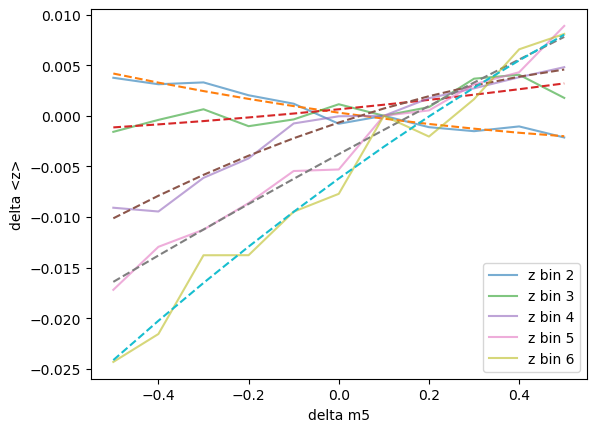

In [177]:
#meanzs = np.zeros( (6,len(bands),len(deltas)) )

tmp = pandas.read_pickle('meanzsy1.pkl')
for i in np.arange(1,6):
    plt.plot(deltas,tmp[i,0,:]-tmp[i,0,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6)
    fitpoly=np.polynomial.polynomial.polyfit(deltas,tmp[i,0,:]-tmp[i,0,6],2)
#    print(fitpoly)
    plt.plot(deltas,np.polynomial.polynomial.polyval(deltas,fitpoly,tensor=True),linestyle='dashed')
    plt.xlabel('delta m5')
    plt.ylabel('delta <z>')
    plt.legend()

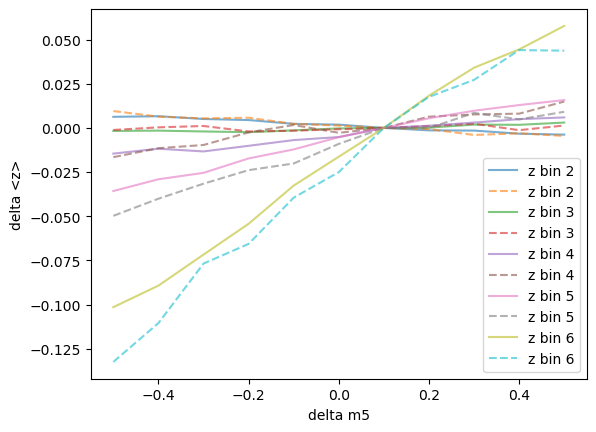

In [178]:
tmp = pandas.read_pickle('meanzsy1.pkl')

for i in np.arange(1,6):
    sumshift = tmp[i,0,:]+tmp[i,1,:]+tmp[i,2,:]+tmp[i,3,:]+tmp[i,4,:]+tmp[i,5,:]
    plt.plot(deltas,tmp[i,6,:]-tmp[i,6,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6)
    plt.plot(deltas,sumshift-sumshift[6],label = 'z bin '+np.array2string((i+1)),alpha=0.6,linestyle='dashed')

#    fitpoly=np.polynomial.polynomial.polyfit(deltas,tmp[i,0,:]-tmp[i,0,6],2)
#    plt.plot(deltas,np.polynomial.polynomial.polyval(deltas,fitpoly,tensor=True),linestyle='dashed')
    plt.xlabel('delta m5')
    plt.ylabel('delta <z>')
    plt.legend()

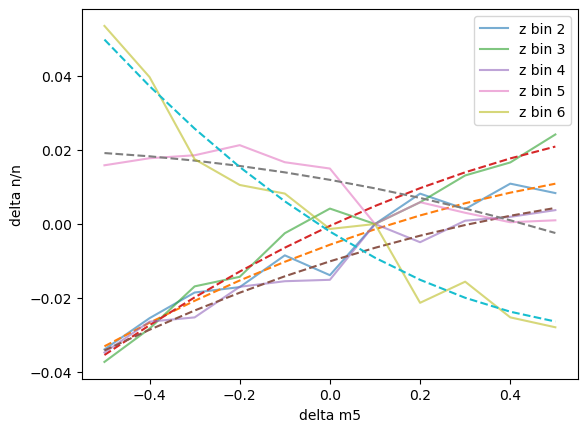

In [179]:
#meanzs = np.zeros( (6,len(bands),len(deltas)) )

tmpd = pandas.read_pickle('densityy1.pkl')
for i in np.arange(1,6):
    plt.plot(deltas,(tmpd[i,0,:]-tmpd[i,0,6])/tmpd[i,0,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6)
    fitpoly=np.polynomial.polynomial.polyfit(deltas,(tmpd[i,0,:]-tmpd[i,0,6])/tmpd[i,0,6],2)
    plt.plot(deltas,np.polynomial.polynomial.polyval(deltas,fitpoly,tensor=True),linestyle='dashed')
    plt.xlabel('delta m5')
    plt.ylabel('delta n/n')
    plt.legend()

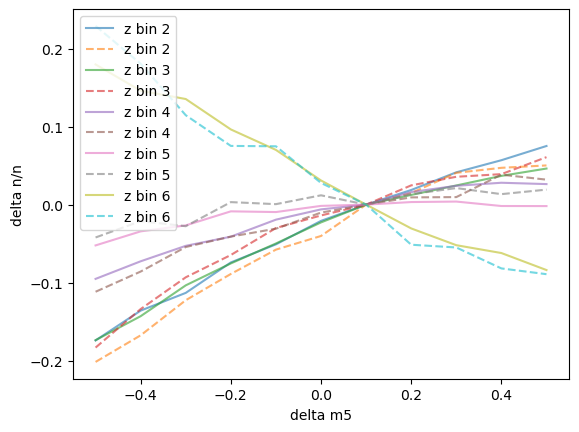

In [180]:
tmpd = pandas.read_pickle('densityy1.pkl')

for i in np.arange(1,6):
    sumshift = tmpd[i,0,:]/tmpd[i,0,6]+tmpd[i,1,:]/tmpd[i,1,6]+tmpd[i,2,:]/tmpd[i,2,6] + \
         tmpd[i,3,:]/tmpd[i,3,6]+tmpd[i,4,:]/tmpd[i,4,6]+tmpd[i,5,:]/tmpd[i,5,6]
    
    plt.plot(deltas,(tmpd[i,6,:]-tmpd[i,6,6])/tmpd[i,6,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6)
    plt.plot(deltas,(sumshift-sumshift[6]),label = 'z bin '+np.array2string((i+1)),alpha=0.6,linestyle='dashed')

#    fitpoly=np.polynomial.polynomial.polyfit(deltas,tmp[i,0,:]-tmp[i,0,6],2)
#    plt.plot(deltas,np.polynomial.polynomial.polyval(deltas,fitpoly,tensor=True),linestyle='dashed')
    plt.xlabel('delta m5')
    plt.ylabel('delta n/n')
    plt.legend()

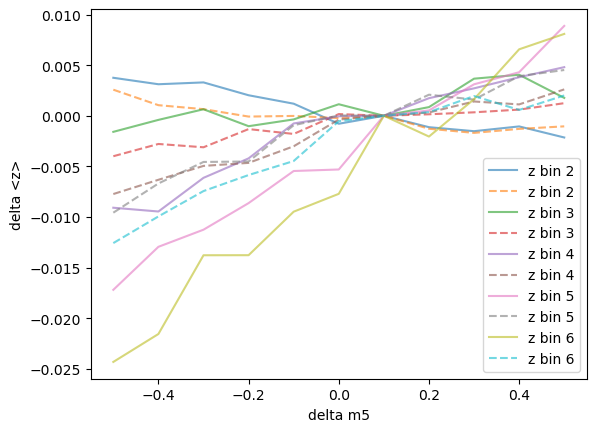

In [181]:
#meanzs = np.zeros( (6,len(bands),len(deltas)) )

tmp = pandas.read_pickle('meanzsy1.pkl')
tmp10 = pandas.read_pickle('meanzsy10.pkl')

for i in np.arange(1,6):
    plt.plot(deltas,tmp[i,0,:]-tmp[i,0,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6)
    plt.plot(deltas,tmp10[i,0,:]-tmp10[i,0,6],label = 'z bin '+np.array2string((i+1)),alpha=0.6,linestyle='dashed')
    plt.xlabel('delta m5')
    plt.ylabel('delta <z>')
    plt.legend()

# This is the code box that does all the new work of fitting derivatives!

In [192]:
years = [1,2,3,4,5,6,7,8,9,10]
nyears = len(years)
nbands = len(bands)
nbins = 5
meanzderiv = np.zeros((nyears,nbands,nbins))
densityderiv = np.zeros((nyears,nbands,nbins))

for year_idx,year in enumerate(years):
    yearstring = np.array2string(np.array(year))
    meanzs = pandas.read_pickle('meanzsy'+yearstring+'.pkl')
    densitys = pandas.read_pickle('densityy'+yearstring+'.pkl')
    for band_idx,band in enumerate(bands):
        for bin_idx in np.arange(1,6):
            fitpoly=np.polynomial.polynomial.polyfit(deltas,
                meanzs[bin_idx,band_idx,:]-meanzs[bin_idx,band_idx,6],2)
            meanzderiv[year_idx,band_idx,bin_idx-1] = fitpoly[1]
            fitpolyd=np.polynomial.polynomial.polyfit(deltas,
                (densitys[bin_idx,band_idx,:]/densitys[bin_idx,band_idx,6]-1),2)
            densityderiv[year_idx,band_idx,bin_idx-1] = fitpolyd[1]


Text(0.5, 0, 'year')

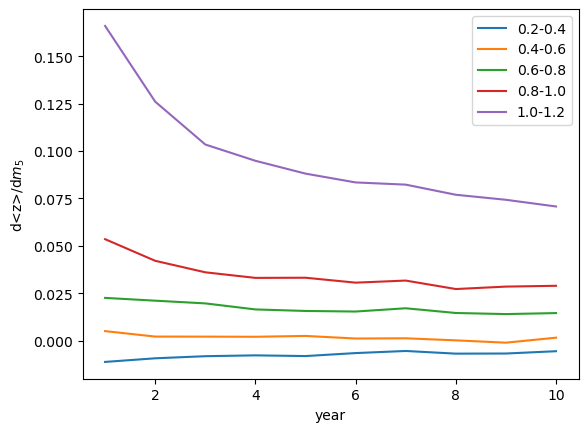

In [191]:
plt.plot(years,meanzderiv[:,6,0],label = '0.2-0.4')
plt.plot(years,meanzderiv[:,6,1],label = '0.4-0.6')
plt.plot(years,meanzderiv[:,6,2],label = '0.6-0.8')
plt.plot(years,meanzderiv[:,6,3],label = '0.8-1.0')
plt.plot(years,meanzderiv[:,6,4],label = '1.0-1.2')
plt.legend()
plt.ylabel(r'd<z>/d$m_5$')
plt.xlabel('year')

Text(0.5, 0, 'year')

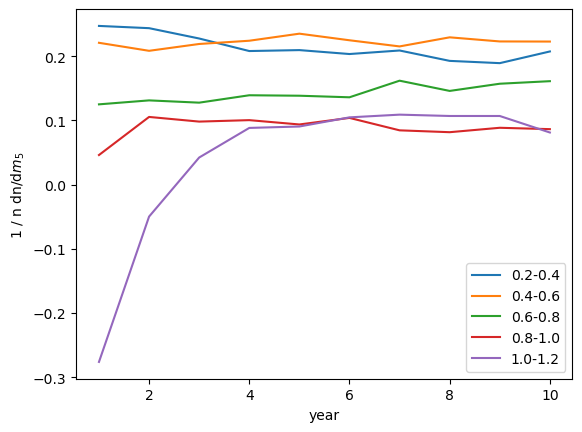

In [194]:
plt.plot(years,densityderiv[:,6,0],label = '0.2-0.4')
plt.plot(years,densityderiv[:,6,1],label = '0.4-0.6')
plt.plot(years,densityderiv[:,6,2],label = '0.6-0.8')
plt.plot(years,densityderiv[:,6,3],label = '0.8-1.0')
plt.plot(years,densityderiv[:,6,4],label = '1.0-1.2')
plt.legend()
plt.ylabel(r'1 / n dn/d$m_5$')
plt.xlabel('year')

In [185]:
tmp = meanzderiv[:,0:6,:]

In [186]:
#tmp.shape
sumderiv = tmp.sum(axis=1)
sumderiv.shape

(10, 5)

0.12275823692907575


(-1.5, 1.5)

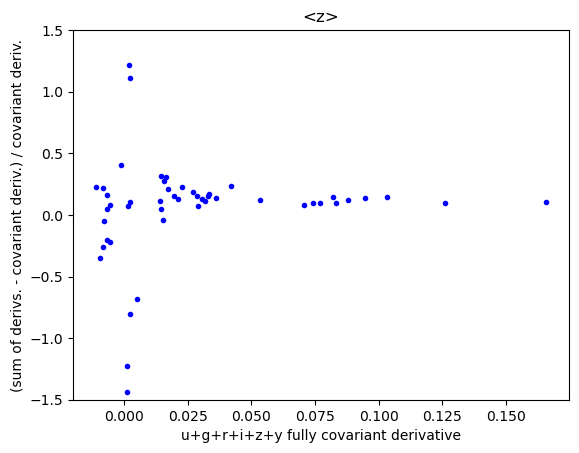

In [187]:
sums = sumderiv.flatten()
covariant = (meanzderiv[:,6,:]).flatten()
plt.plot(covariant,(sums - covariant)/covariant,'b.')
plt.xlabel('u+g+r+i+z+y fully covariant derivative')
ylabel(r'(sum of derivs. - covariant deriv.) / covariant deriv.')
print(np.median(-(covariant - sums)/covariant))
plt.title('<z>')
plt.ylim(-1.5,1.5)

0.058799512450450384


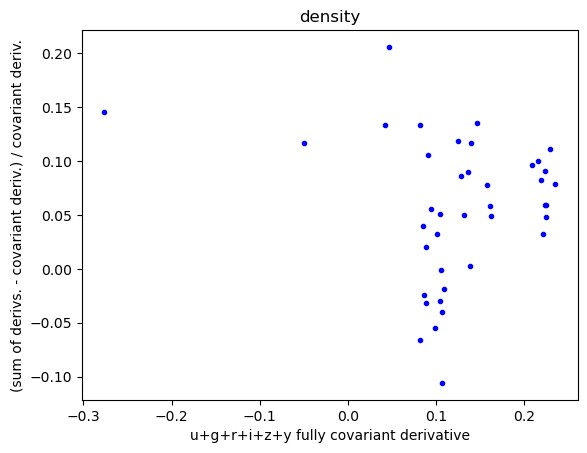

In [197]:
tmp = densityderiv[:,0:6,1:5]

sumderiv = tmp.sum(axis=1)
sumderiv.shape

sums = sumderiv.flatten()
covariant = (densityderiv[:,6,1:5]).flatten()
plt.plot(covariant,(sums - covariant)/covariant,'b.')
plt.xlabel('u+g+r+i+z+y fully covariant derivative')
ylabel(r'(sum of derivs. - covariant deriv.) / covariant deriv.')
plt.title('density')
print(np.median(-(covariant - sums)/covariant))

In [203]:
np.std((sums - covariant)/covariant)

0.06579563528202678

(10, 6, 4)

In [189]:
#meanzderiv: axes are ((nyears,nbands,nbins))
#densityderiv: axes are ((nyears,nbands,nbins))

# array of the years used (corresponding to first axis of the results arrays)
pickle.dump(years, open('years.pkl', "wb"))

# array of the bands used (corresponding to second axis)
pickle.dump(bands, open('bands.pkl', "wb"))

minzs=np.linspace(0.2, 1.0,5)
maxzs=minzs+0.2

# array of the minz of each redshift bin  (corresponding to third axis)
pickle.dump(minzs, open('minzs.pkl', "wb"))

# array of the maxz of each redshift bin  (corresponding to third axis)
pickle.dump(maxzs, open('maxzs.pkl', "wb"))

# array of the derivative of <z> with respect to m5, for each combination
#    of year, band, and bin number
# i.e. axes are ((nyears,nbands,nbins))
pickle.dump(meanzderiv, open('meanzderiv.pkl', "wb"))

# array of the logatiyhmic derivative of n with respect to m5 
# (i.e., 1/n * dn/dm5), for each combination
#    of year, band, and bin number
# i.e. axes are ((nyears,nbands,nbins))
pickle.dump(densityderiv, open('densityderiv.pkl', "wb"))


In [154]:
!pwd

/global/u1/j/janewman/uniformity


In [155]:
!chmod a+r *.*


In [162]:
!chmod g+x ../../janewman

In [158]:
!ls -pasl

total 1392
  8 drwxrwxr--  3 janewman janewman   4096 Mar  8 00:04 ./
  8 drwxr-xr-x 23 janewman desi       4096 Mar  7 12:29 ../
  1 -rw-rw-r--  1 janewman janewman     49 Mar  7 23:04 bands.pkl
  1 -rw-rw-r--  1 janewman janewman    235 Mar  7 21:17 deltas.pkl
  4 -rw-rw-r--  1 janewman janewman   2954 Mar  7 23:04 densityderiv.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 23:42 densityy10.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 18:31 densityy1.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 18:54 densityy2.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 19:20 densityy3.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 19:50 densityy4.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 20:23 densityy5.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 21:00 densityy6.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 21:37 densityy7.pkl
  4 -rw-rw-r--  1 janewman janewman   3850 Mar  7 22:18 densityy8.pkl
  4 -rw-rw-r--  1 janewman janewm